# <center> Predicting Wins in NCAA Men's Basketball </center>
<center> Derek Lore, Christopher Nalty, Michael Stephanus </center>

## <center> Introduction </center>

We're Playing Basketballllllllllll, we're playing basketballllll.



## <center> Gathering the Data </center>

The First piece of data we're going to gather is all of the game results for Division 1 games in the 2018-2019 season. 
We're going to get that data from a site called [Sports Reference](https://www.sports-reference.com/cbb/boxscores/). 
This site formats there urls for boxscore to include the month, day, and year you're looking at. Using this we can create
a loop do go through all the dates in the season and download the box scores for each game. We add a short sleep after each day
since we're sending a lot get requests to prevent any connection interruptions on either end.

In [11]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time

box_scores = pd.DataFrame(columns=["date", "win_team", "lose_team", "win_score", "lose_score"])

url_format = "https://www.sports-reference.com/cbb/boxscores/index.cgi?month={}&day={}&year={}"
for y in [2018, 2019]:
    months = []
    if y == 2018:
        months = [11, 12]
    else:
        months = [1, 2, 3, 4]
    
    for m in months:
        days = range(1,32)
        for d in days:
            url = url_format.format(str(m),str(d),str(y))
            r = requests.get(url)

            root = BeautifulSoup(r.content)
            root.prettify()
            t = root.find("div", class_="game_summaries")
            #date = t.find("h2").getText()
            date = str(m) + "/" + str(d) + "/" + str(y)
    
            for i in root.find_all("div", class_="game_summary nohover"):
                loser = i.find("tr", class_="loser")
                lose_team = loser.find("a").getText()
                lose_score = loser.find("td", class_="right").getText()
    
                winner = i.find("tr", class_="winner")
                win_team = winner.find("a").getText()
                win_score = winner.find("td", class_="right").getText()
                
                box_scores = box_scores.append({"date":date, "win_team":win_team, "lose_team":lose_team, "win_score":win_score, "lose_score":lose_score}, ignore_index=True)
            
            time.sleep(0.5)

box_scores.head()

,date,win_team,lose_team,win_score,lose_score
0,11/6/2018,Kansas,Michigan State,92,87
1,11/6/2018,Duke,Kentucky,118,84
2,11/6/2018,Gonzaga,Idaho State,120,79
3,11/6/2018,Virginia,Towson,73,42
4,11/6/2018,Tennessee,Lenoir-Rhyne,86,41


The next piece of data we're going to gather is the ranks for each team from the ap polls of each week. We're also going
get this information from [Sports Reference](https://www.sports-reference.com/cbb/seasons/2019-polls.html). This site
has a csv formatted table we can just copy and paste into a file and read with pandas.

In [12]:
ranks = pd.read_csv("apranks.csv") # found here https://www.sports-reference.com/cbb/seasons/2019-polls.html

ranks.head()


,School,Conf,Pre,11/12,11/19,11/26,12/03,12/10,12/17,12/24,...,01/14,01/21,01/28,02/04,02/11,02/18,02/25,03/04,03/11,Final
0,Arizona State,Pac-12,NaN,NaN,NaN,NaN,20.0,20.0,18.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Auburn,SEC,11.0,9.0,8.0,8.0,8.0,8.0,7.0,12.0,...,14.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,14.0
2,Buffalo,MAC,NaN,25.0,22.0,21.0,17.0,14.0,14.0,21.0,...,16.0,14.0,18.0,23.0,25.0,25.0,21.0,19.0,18.0,15.0
3,Cincinnati,AAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25.0,NaN,NaN,23.0,20.0,24.0,22.0
4,Clemson,ACC,22.0,19.0,16.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The last piece of data we need to do is to acquire all of the team statistical data by week from the NCAA website. This way
we can use to date accurate data for training and validation of our prediction model later on. Using only end of season statistics
could have an effect on the prediction since teams stats will change as a season progresses. The data we're going to be using can be located at [http://web1.ncaa.org/stats/StatsSrv/rankings?sportCode=MBB]. This page requires us to do some clicking, 
and doesn't have all of the stats centralized in one csv. So to automate this we will use selenium, instead of doing ~12000 
clicks ourselves. To do this we used the chrome based webdriver in selenium, to run this script you will need the 
[ChromeDriver](https://chromedriver.chromium.org/downloads). Once we have this installed we can now the following script 
to download every team stat available from every date of the 2018-2019 Men's Basketball season.

In [13]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
options = Options()
prefs = {'download.default_directory' : r'/home/chris/git/final320project/stats'}
print(prefs['download.default_directory'])
options.add_experimental_option('prefs', prefs)

driver = webdriver.Chrome("/home/chris/Downloads/chromedriver", chrome_options=options) # change this to where ever your driver is

# select division one button, since that's all we care about, will stay persistent
driver.get("http://web1.ncaa.org/stats/StatsSrv/rankings?sportCode=MBB")
div1 = driver.find_element_by_xpath("/html/body/form/table[3]/tbody/tr[2]/td/select/option[2]").click()
week_base = "/html/body/form/table[3]/tbody/tr[5]/td/select/option[{}]" # base string for selecting week
stats_base = "/html/body/form/table[3]/tbody/tr[10]/td/select/option[{}]" # base for stats

for i in range(2, 142):
    driver.find_element_by_xpath(week_base.format(i)).click()
    for j in range(3, 33):
        driver.find_element_by_xpath(stats_base.format(j)).click()
        driver.find_element_by_xpath("/html/body/form/table[3]/tbody/tr[13]/td/input[4]").click()
        
driver.quit()

/home/chris/git/final320project/stats


/home/chris/git/final320project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


Next we need to load all of this data into dataframes to use. Since for win prediction we're going to be looking at
stats by week, and pandas doesn't work well with relational databases, we're going to use a dictionary of dataframes as
a representation of our relational database. The dictionary keys will act like foreign keys to a respective dataframes.

In [14]:
import os
import io

dfs = {}
# walk the files saved from the data download

for _, _, files in os.walk('stats'):
    for file in files:
        csv = ""
        s = ""
        # open the file and create a new string with only the csv contents
        #print(file)
        with open(os.path.join("stats/", file), 'r') as f:
            s = f.read()
            i = 0
            date = ""
            for line in s.splitlines():
                if i == 8:
                    date = line[14:]
                if (i > 10 and i < 363 or i == 364 or i == 365) and "," in line:
                    csv += line+"\n"
                i = i + 1
        if date in dfs:
            ndata = pd.read_csv(io.StringIO(csv))
            for c1 in dfs[date].columns:
                if c1 in ndata.columns and c1 != "Name":
                    del ndata[c1]
            dfs[date] = dfs[date].merge(ndata)
        else:
            dfs[date] = pd.read_csv(io.StringIO(csv))

rankings - 2019-12-14T185508.499.csv
rankings - 2019-12-14T190101.649.csv
rankings - 2019-12-14T191729.916.csv
rankings - 2019-12-14T191730.894.csv
rankings - 2019-12-14T184927.869.csv
rankings - 2019-12-14T191349.700.csv
rankings - 2019-12-14T190024.338.csv
rankings - 2019-12-14T185810.300.csv
rankings - 2019-12-14T184711.571.csv
rankings - 2019-12-14T191951.836.csv
rankings - 2019-12-14T190026.177.csv
rankings - 2019-12-14T190855.292.csv
rankings - 2019-12-14T184404.931.csv
rankings - 2019-12-14T190544.679.csv
rankings - 2019-12-14T191502.401.csv
rankings - 2019-12-14T191158.076.csv
rankings - 2019-12-14T190242.001.csv
rankings - 2019-12-14T184607.175.csv
rankings - 2019-12-14T185105.990.csv
rankings - 2019-12-14T191922.496.csv
rankings - 2019-12-14T185758.996.csv
rankings - 2019-12-14T185750.193.csv
rankings - 2019-12-14T190253.297.csv
rankings - 2019-12-14T185534.429.csv
rankings (35).csv
rankings - 2019-12-14T190452.100.csv
rankings - 2019-12-14T191457.030.csv
rankings - 2019-12-1

## <center> Cleaning and Tidying the Data </center>

The Data for Box Scores is already Clean and Tidy, it's clear how to access all of the games with well organized columns and rows.
So, we can leave this dataframe as is. 

In [15]:
box_scores.head()

,date,win_team,lose_team,win_score,lose_score
0,11/6/2018,Kansas,Michigan State,92,87
1,11/6/2018,Duke,Kentucky,118,84
2,11/6/2018,Gonzaga,Idaho State,120,79
3,11/6/2018,Virginia,Towson,73,42
4,11/6/2018,Tennessee,Lenoir-Rhyne,86,41


Next we want to look at the ranks dataframe. This data frame is full of missing data, since there are many teams that aren't
ranked in the top 25 every week. Many of them dip in and out of the rankings each week. We would also like the indexes be
the date instead of the school name. We're going to tidy this data up by creating a new dataframe with the dates as the index,
like we desired, and a column for each rank, 1-25, with the columns value as the name of the team of the rank.

In [16]:
import re

new_ranks = pd.DataFrame(index=[i for i in range(1, 26)])

# here we go through each data (and Final) add add the team names into each rank index with a new column for the date
for elem in ranks.columns:
    if re.match("(\d{1,2}\/\d{1,2})|(Final)", elem):
        date_dict = ranks.set_index("School")[elem].dropna().to_dict()
        rev_dict = {}
        for k, v in date_dict.items():
            rev_dict[v] = k

        new_ranks[elem] = pd.Series(rev_dict)

print(new_ranks.head())

       11/12      11/19     11/26     12/03      12/10      12/17      12/24  \
1       Duke       Duke   Gonzaga   Gonzaga     Kansas     Kansas       Duke   
2     Kansas     Kansas    Kansas    Kansas       Duke       Duke   Michigan   
3    Gonzaga    Gonzaga      Duke      Duke  Tennessee  Tennessee  Tennessee   
4   Virginia   Virginia  Virginia  Virginia    Gonzaga   Michigan   Virginia   
5  Tennessee  Tennessee    Nevada  Michigan   Michigan   Virginia     Kansas   

       12/31      01/07      01/14      01/21      01/28      02/04  \
1       Duke       Duke       Duke  Tennessee  Tennessee  Tennessee   
2   Michigan   Michigan   Michigan       Duke       Duke       Duke   
3  Tennessee  Tennessee  Tennessee   Virginia   Virginia   Virginia   
4   Virginia   Virginia   Virginia    Gonzaga    Gonzaga    Gonzaga   
5     Kansas    Gonzaga    Gonzaga   Michigan   Michigan   Kentucky   

       02/11      02/18     02/25      03/04     03/11           Final  
1  Tennessee       

Now that we've gotten rid of the NA values we can take the tranpose of the data frame to have dates as the index like we wanted
We also need to add the date year onto the dates so they correspond with stats dataframe.

In [17]:
new_ranks = new_ranks.transpose()

new_ranks = new_ranks.rename(index=lambda x: re.sub("^0.*", x + "/2019", x))
new_ranks = new_ranks.rename(index=lambda x: re.sub("^1.*", x + "/2018", x))
new_ranks = new_ranks.rename(index=lambda x: re.sub("Final", '03/21/2019', x))

print(new_ranks.head())

                 1       2          3         4          5          6   \
11/12/2018     Duke  Kansas    Gonzaga  Virginia  Tennessee     Nevada   
11/19/2018     Duke  Kansas    Gonzaga  Virginia  Tennessee     Nevada   
11/26/2018  Gonzaga  Kansas       Duke  Virginia     Nevada  Tennessee   
12/03/2018  Gonzaga  Kansas       Duke  Virginia   Michigan     Nevada   
12/10/2018   Kansas    Duke  Tennessee   Gonzaga   Michigan   Virginia   

                   7          8               9               10  ...  \
11/12/2018        UNC  Villanova          Auburn        Kentucky  ...   
11/19/2018        UNC     Auburn        Michigan        Kentucky  ...   
11/26/2018   Michigan     Auburn  Michigan State        Kentucky  ...   
12/03/2018  Tennessee     Auburn        Kentucky  Michigan State  ...   
12/10/2018     Nevada     Auburn  Michigan State   Florida State  ...   

                       16                 17                 18          19  \
11/12/2018  Virginia Tech  Mississipp

We should also check to make sure that every date in our ranks column corresponds to a date in the stats dataframe we have
so we have easy access between both. We'll use difflib to print out the nearest matches for any dates that aren't found.

In [18]:
import difflib

for date in new_ranks.index:
    if date not in dfs.keys():
        print(date)
        # here we can see candidates
        print(difflib.get_close_matches(date, dfs.keys()))

12/24/2018
['12/28/2018', '12/27/2018', '12/25/2018']
02/11/2019
['03/11/2019', '02/21/2019', '02/19/2019']


We can see there are two dates that don't have a match and there nearest matches in the statistics dataframes. We want to
make the ranks correspond to the next date after the ranks have been released

In [19]:
new_ranks = new_ranks.rename(index=lambda x: re.sub("12/24/2018", '12/25/2018', x))
new_ranks = new_ranks.rename(index=lambda x: re.sub("02/11/2019", '02/19/2019', x))

Finally we need to clean the statistics dataframes themselves. We're going to remove the "Rank" column since this is a relic
that corresponds to the rank for one of the statistics during each week, and it is not useful information to us.

In [20]:
for k in dfs.keys():
    dfs[k] = dfs[k].drop("Rank", axis=1)

## <center> Exploratory Data Analysis </center>

Now that are data is tidied it's time for us to look at our data and see if we can find any trends in our data. Let's start
by graphing some of the stats for the number one ranked teams for each week and see if there is a trend. If a stat is very
important for a team to be ranked number one, we'd expect the value to stay approximately the same from week to week.
First we'll check which teams are ranked number one throughout the season to see how varied the position is.

In [21]:
rank1s = new_ranks[1]
rank1s

11/12/2018         Duke
11/19/2018         Duke
11/26/2018      Gonzaga
12/03/2018      Gonzaga
12/10/2018       Kansas
12/17/2018       Kansas
12/25/2018         Duke
12/31/2018         Duke
01/07/2019         Duke
01/14/2019         Duke
01/21/2019    Tennessee
01/28/2019    Tennessee
02/04/2019    Tennessee
02/19/2019    Tennessee
02/18/2019         Duke
02/25/2019      Gonzaga
03/04/2019      Gonzaga
03/11/2019      Gonzaga
03/21/2019         Duke
Name: 1, dtype: object

We can see that there are only 4 different teams during the entire season that hold the number one spot. We'll create a custom
legend for each team when graphing so we can get a sense of if stats are jumping around due to different teams holding rank 1
or if it's due to other causes

Let's start by graphing Field Goal percentage. This is a stat we would expected to have a very strong correlation with win rate,
meaning it should stay at a near constant value for rank 1 teams from week to week.

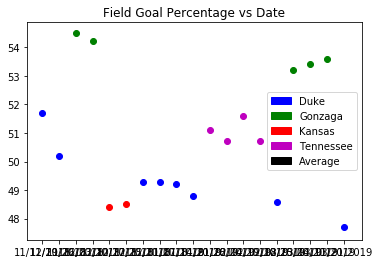

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

t_cols = {'Duke':'b', 'Gonzaga':'g', 'Kansas':'r', 'Tennessee':'m', 'Average': 'k'}

# we need to create a custom legend so points Teams aren't repeated

patches = [mpatches.Patch(color=v, label=k) for k, v in t_cols.items()]

for index in rank1s.index:
    if index in dfs.keys():
        curr_y = dfs[index].loc[dfs[index]['Name'] == rank1s[index]]['FG%'].values[0]
        plt.scatter(index, curr_y, c=t_cols[rank1s[index]])

plt.title('Field Goal Percentage vs Date')
plt.legend(handles=patches)
plt.show()

Unfortunately Field Goal Percentage doesn't seem to stay very consistent throughout the season for rank 1. However, we can
see that the teams themselves hold consistent numbers during the season. Since we see that not all stats are going to show
the entire picture for rank 1, it may be a good idea to also add the average values to try to get a better picture of 
where the rank 1 teams stats stand. Now we'll graph a few more stats with the average added.

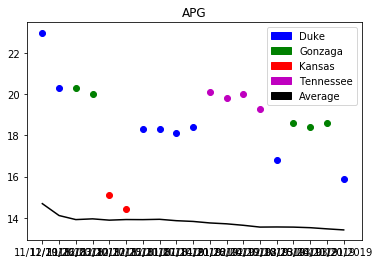

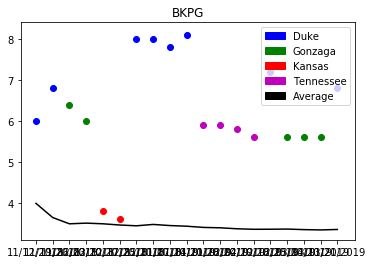

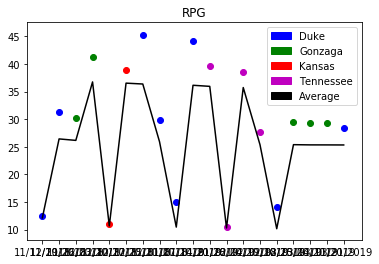

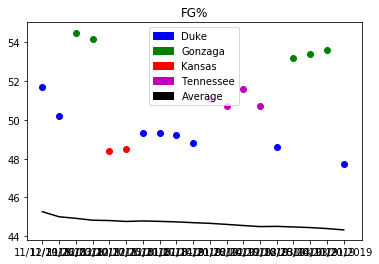

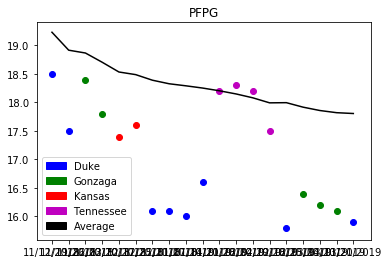

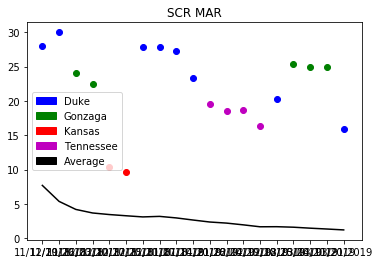

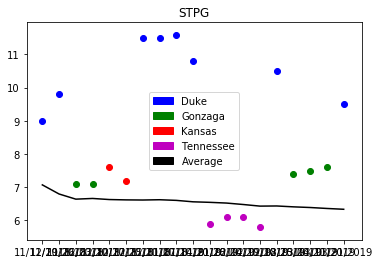

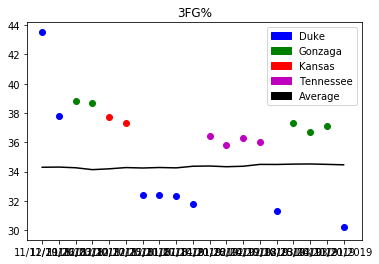

In [27]:
stats_to_graph = ["APG", "BKPG", "RPG", "FG%", "PFPG", "SCR MAR", "STPG", "3FG%"]

for stat in stats_to_graph:
    dates = []
    avgs = []
    for index in rank1s.index:
        if index in dfs.keys():
            dates.append(index)
            curr_y = dfs[index].loc[dfs[index]['Name'] == rank1s[index]][stat].values[0]
            plt.scatter(index, curr_y, c=t_cols[rank1s[index]])

            avgs.append(dfs[index][stat].mean())
    plt.plot(dates, avgs, c=t_cols['Average'])
    plt.title(stat)
    plt.legend(handles=patches)
    plt.show()
    

From these graphs, if one stat is very important to being rank 1, we'd expect all the teams to have a very similar
value for such stats. However it seems all of the stats, except 3-point field goal percentage and rebounds per game,
have a very large variations in values for week to week. We can see however that each team tends to keep fairly 
consistent on each stat from week to week. 3-point field goal percentage being more consistent would lead us to 
believe this is a more important stat to being rank one than others. 

We can see that even though the number one ranked team doesn't seem to lean on any one stat they excel comparted to 
average team in Division 1. There are are a couple stats, such as Steals Per Game, where Tennessee is worse than the
average, and 3-point field goal percentage where Duke is below average in the later half of the season, but outside
these two occurrences it's clear these teams outperform most of the Division.